In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
from transformers import AutoImageProcessor, ViTForImageClassification
from torch import nn

# Device & Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

NUM_EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 3e-5

Mounted at /content/drive
Using device: cuda


In [ ]:
zip_path = "/content/drive/MyDrive/pre_processed_brain-tumor-dataset.zip"  # adjust path
extract_path = "/content/pre_processed_brain-tumor-dataset"

if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Update EXTRACT_PATH to point to the inner folder
EXTRACT_PATH = os.path.join(extract_path, "pre_processed_brain-tumor-dataset")
print("Dataset root:", EXTRACT_PATH)
print("Contents:", os.listdir(EXTRACT_PATH))

Extracting dataset...
Extraction complete.
Dataset root: /content/pre_processed_brain-tumor-dataset/pre_processed_brain-tumor-dataset
Contents: ['Training', 'Testing', 'Validation']


In [ ]:
def load_dataset_structure(root_dir):
    """
    Loads dataset splits (train/val/test) and returns lists of image paths and labels.
    """
    expected = {"train": "training", "val": "validation", "test": "testing"}
    found = {}
    available_dirs = {d.lower(): d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))}
    print("Found split folders:", available_dirs)

    for key, expected_name in expected.items():
        if expected_name in available_dirs:
            found[key] = available_dirs[expected_name]
        else:
            raise FileNotFoundError(
                f"Expected '{expected_name}' inside {root_dir}, but found only: {list(available_dirs.values())}"
            )

    data = {}
    class_names = None

    for key, folder in found.items():
        split_path = os.path.join(root_dir, folder)
        images, labels = [], []
        classes = sorted(os.listdir(split_path))
        if class_names is None:
            class_names = classes

        for label, cls in enumerate(classes):
            cls_path = os.path.join(split_path, cls)
            for ext in ("*.jpg", "*.jpeg", "*.png"):
                files = glob(os.path.join(cls_path, ext))
                images.extend(files)
                labels.extend([label] * len(files))

        data[key] = (images, labels)

    return data["train"], data["val"], data["test"], class_names

# Load dataset
(train_imgs, train_lbls), (val_imgs, val_lbls), (test_imgs, test_lbls), class_names = load_dataset_structure(EXTRACT_PATH)
print(f"Classes: {class_names}")
print(f"Samples — Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

📂 Found split folders: {'training': 'Training', 'testing': 'Testing', 'validation': 'Validation'}
✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Samples — Train: 5712, Val: 1055, Test: 256


In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, processor, train_mode=False):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.train_mode = train_mode

        if self.train_mode:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB").resize((224, 224))
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        pixel_values = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze()
        return {"pixel_values": pixel_values, "labels": label}

def prepare_dataloader(images, labels, processor, batch_size=16, shuffle=True, train_mode=False):
    dataset = BrainTumorDataset(images, labels, processor, train_mode=train_mode)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True,
    )

# Initialize processor
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Prepare DataLoaders
train_loader = prepare_dataloader(train_imgs, train_lbls, processor, batch_size=BATCH_SIZE, shuffle=True, train_mode=True)
val_loader   = prepare_dataloader(val_imgs, val_lbls, processor, batch_size=BATCH_SIZE, shuffle=False, train_mode=False)
test_loader  = prepare_dataloader(test_imgs, test_lbls, processor, batch_size=BATCH_SIZE, shuffle=False, train_mode=False)

print("✅ Dataloaders ready.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Dataloaders ready.


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(class_names),
    ignore_mismatched_sizes=True,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
).to(DEVICE)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def evaluate(model, dataloader, loss_fn):
    model.eval()
    loss_accum = 0.0
    preds, targets = [], []

    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            loss_accum += loss.item()
            _, pred = torch.max(logits, 1)
            preds.extend(pred.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = loss_accum / len(dataloader)
    acc = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(targets, preds, average="weighted", zero_division=0)
    return avg_loss, acc, prec, rec, f1, targets, preds

In [ ]:
def train_model_with_early_stopping(model, train_loader, val_loader, patience=7):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    early_stopping = EarlyStopping(patience=patience)

    # History dictionary to store all metrics
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "train_prec": [], "val_prec": [],
        "train_rec": [], "val_rec": [],
        "train_f1": [], "val_f1": []
    }

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss_accum = 0.0
        train_preds, train_labels = [], []

        # --- Training loop ---
        for batch in train_loader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss_accum += loss.item()
            _, preds = torch.max(logits, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # --- Compute training metrics ---
        train_loss = train_loss_accum / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average="weighted", zero_division=0
        )

        # --- Validation metrics ---
        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(model, val_loader, loss_fn)

        # --- Print epoch summary ---
        print(
            f"Epoch {epoch+1}/{NUM_EPOCHS} | "
            f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}, F1={train_f1:.4f} | "
            f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}"
        )

        # --- Store metrics in history ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_prec"].append(train_prec)
        history["val_prec"].append(val_prec)
        history["train_rec"].append(train_rec)
        history["val_rec"].append(val_rec)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        scheduler.step()
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered!")
            break

    return history
history = train_model_with_early_stopping(model, train_loader, val_loader, patience=7)

Epoch 1/50 | Train: Loss=0.7719, Acc=0.7938, Prec=0.7938, Rec=0.7938, F1=0.7916 | Val: Loss=0.6008, Acc=0.8777, Prec=0.8828, Rec=0.8777, F1=0.8760
Epoch 2/50 | Train: Loss=0.5656, Acc=0.8867, Prec=0.8864, Rec=0.8867, F1=0.8865 | Val: Loss=0.4672, Acc=0.9441, Prec=0.9439, Rec=0.9441, F1=0.9439
Epoch 3/50 | Train: Loss=0.5258, Acc=0.9090, Prec=0.9086, Rec=0.9090, F1=0.9087 | Val: Loss=0.4661, Acc=0.9365, Prec=0.9388, Rec=0.9365, F1=0.9363
Epoch 4/50 | Train: Loss=0.4941, Acc=0.9237, Prec=0.9234, Rec=0.9237, F1=0.9234 | Val: Loss=0.4257, Acc=0.9592, Prec=0.9598, Rec=0.9592, F1=0.9593
Epoch 5/50 | Train: Loss=0.4763, Acc=0.9329, Prec=0.9328, Rec=0.9329, F1=0.9329 | Val: Loss=0.4284, Acc=0.9564, Prec=0.9572, Rec=0.9564, F1=0.9562
Epoch 6/50 | Train: Loss=0.4741, Acc=0.9361, Prec=0.9360, Rec=0.9361, F1=0.9361 | Val: Loss=0.3947, Acc=0.9801, Prec=0.9804, Rec=0.9801, F1=0.9801
Epoch 7/50 | Train: Loss=0.4601, Acc=0.9435, Prec=0.9432, Rec=0.9435, F1=0.9433 | Val: Loss=0.4186, Acc=0.9659, Prec=0

In [ ]:
 # Define the path where to save the model
save_path = "/content/drive/MyDrive/vit_brain_tumor_model/vit_brain_tumor_model.pth"

# Move the model to CPU before saving (for portability)
model_cpu = model.to('cpu')

# Save only the model weights (state dict)
torch.save(model_cpu.state_dict(), save_path)

print(f"✅ Model successfully saved at: {save_path}")

# Move model back to GPU if you want to continue working
model.to('cuda')

✅ Model successfully saved at: /content/drive/MyDrive/vit_brain_tumor_model/vit_brain_tumor_model.pth


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
from transformers import ViTConfig, ViTForImageClassification
import torch
import os

save_path = "/content/drive/MyDrive/vit_brain_tumor_model/vit_brain_tumor_model.pth"

if os.path.exists(save_path):
    print(f"✅ File found at: {save_path}")
else:
    print(f" ERROR: File NOT found at {save_path}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Create model config with your number of classes (4)
config = ViTConfig.from_pretrained("google/vit-base-patch16-224", num_labels=4)

# 2. Initialize model with this config
loaded_model = ViTForImageClassification(config)

# 3. Load your saved weights (state dict)
loaded_model.load_state_dict(torch.load(save_path, map_location=DEVICE))

# 4. Move model to device
loaded_model.to(DEVICE)

print("✅ Model loaded successfully with correct classifier size!")


✅ File found at: /content/drive/MyDrive/vit_brain_tumor_model/vit_brain_tumor_model.pth
✅ Model loaded successfully with correct classifier size!


In [ ]:
# Print number of parameters and device
num_params = sum(p.numel() for p in loaded_model.parameters())
print(f"Model has {num_params:,} parameters.")

# Check device of first parameter to confirm model is on correct device
first_param = next(loaded_model.parameters())
print(f"Model loaded on device: {first_param.device}")


Model has 85,801,732 parameters.
Model loaded on device: cuda:0



🧪 Test Results:
   🔻 Loss:        0.0896
   🎯 Accuracy:    0.9922
   📌 Precision:   0.9923
   📈 Recall:      0.9922
   💡 F1 Score:    0.9921

📊 Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00        50
  meningioma       1.00      0.96      0.98        56
     notumor       0.99      1.00      1.00       100
   pituitary       0.98      1.00      0.99        50

    accuracy                           0.99       256
   macro avg       0.99      0.99      0.99       256
weighted avg       0.99      0.99      0.99       256



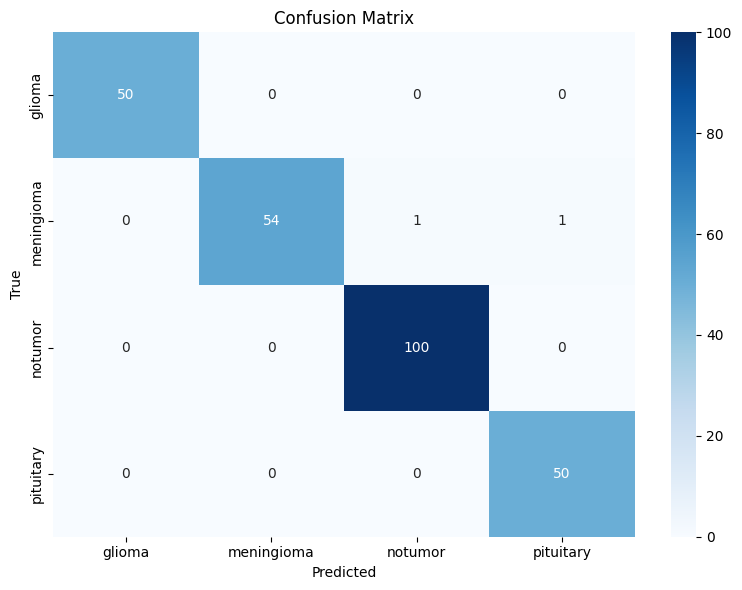

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def test_model(model, test_loader, class_names, loss_fn=torch.nn.CrossEntropyLoss()):
    model.eval()
    preds, targets = [], []
    total_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Compute metrics
    avg_loss = total_loss / len(test_loader)
    acc = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average='weighted', zero_division=0)
    recall = recall_score(targets, preds, average='weighted', zero_division=0)
    f1 = f1_score(targets, preds, average='weighted', zero_division=0)

    # Print metrics
    print(f"\n🧪 Test Results:")
    print(f"   🔻 Loss:        {avg_loss:.4f}")
    print(f"   🎯 Accuracy:    {acc:.4f}")
    print(f"   📌 Precision:   {precision:.4f}")
    print(f"   📈 Recall:      {recall:.4f}")
    print(f"   💡 F1 Score:    {f1:.4f}")

    # Detailed classification report
    print("\n📊 Classification Report:")
    print(classification_report(targets, preds, target_names=class_names, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return preds, targets
test_preds, test_targets = test_model(loaded_model, test_loader, class_names)

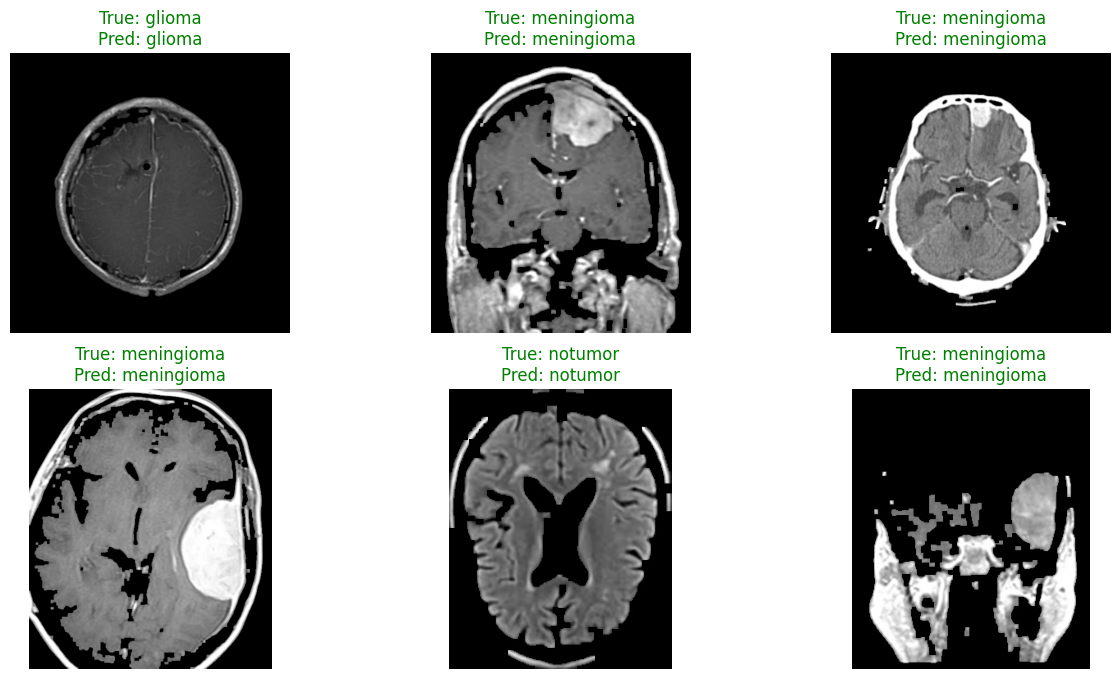

In [ ]:
def visualize_predictions(model, processor, image_paths, labels, class_names, num_samples=6):
    model.eval()
    samples = random.sample(list(zip(image_paths, labels)), num_samples)

    plt.figure(figsize=(15, 8))
    for i, (img_path, true_label) in enumerate(samples):
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1).cpu().item()

        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(
            f"True: {class_names[true_label]}\nPred: {class_names[preds]}",
            color=("green" if preds == true_label else "red")
        )
    plt.show()

# Visualize test predictions
visualize_predictions(loaded_model, loaded_processor, test_imgs, test_lbls, class_names, num_samples=6)